## Fashion Image Retrieval with Auto-Encoder

[Korean](01_garbage.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Contents Bbased Image Retrieval(CBIR) 모델을 학습하는 과정을 다루고 있습니다.
- Reference : https://www.kaggle.com/code/theaayushbajaj/content-based-image-retrieval-pytorch

## Process
1. Data : 데이터 수집 및 분석
2. Modeling : Auto-encoder 모델 생성
3. Training : 모델 학습 진행
4. Inference(Image Retrieval) : 유사이미지 검색

## 1.Data (데이터 수집 및 분석)
- 데이터 수집은 최초 한번으로 끝나는 것이 아닌 이후 모델링, 학습, 평가 기간동안 계속해서 염두해야 합니다.
- 데이터 분석은 정량적, 정성적으로 살펴보아야 합니다.

### 1.1. Summary

- Dataset Download : https://www.kaggle.com/datasets/rizzsum/basic-pattern-women-clothing-dataset
- Dataset Tree
    ```
        dataset
            └── floral	: 380 files
            └── leaf	: 380 files
            └── heart	: 380 files
            └── diamond	: 380 files
            └── animal	: 380 files
            └── stripes	: 380 files
            └── check	: 380 files
            └── polka dots	: 380 files
            └── chevron	: 380 files
            └── paisley	: 380 files
           
    ```
- Dataset Configuration
    - The number of images : 3800 files

### 1.2. Data Analysis

실제 데이터에 어떤 이미지가 있는지 살펴봅니다.

(Optional) gdrive에 있는 데이터를 mount 할때 아래와 같이 mount 후 데이터 경로를 지정해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_main = "/content/gdrive/MyDrive/dataset/fashion"

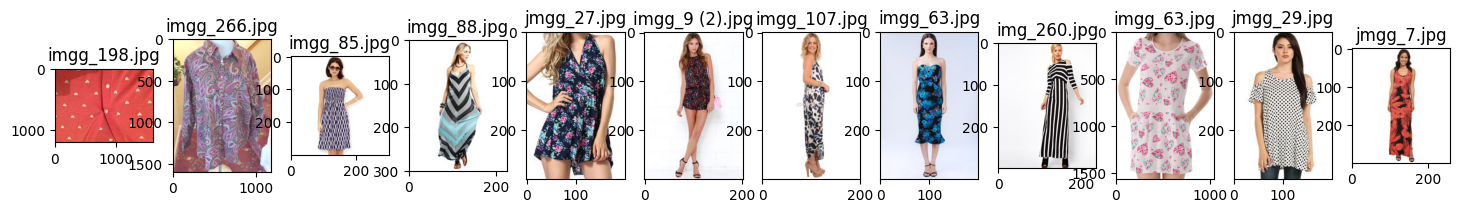

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image

img_dir = "./basicpattern_3800/"
image_paths = glob(f"{img_dir}*/*.jpg")

n_show = 12
samples = np.random.choice(image_paths, n_show)

fig, axes = plt.subplots(nrows=1, ncols=n_show, figsize=(18,2))
for idx, image_path in enumerate(samples):
    img = Image.open(image_path)
    axes[idx].set_title(f"{os.path.basename(image_path)}")
    axes[idx].imshow(img)

### 1.3. Split Train and Validation dataset

In [5]:
from pathlib import Path
import pandas as pd

# Fashion 디렉토리 경로를 Path 객체로 가져옵니다.
datasetPath = Path('./basicpattern_3800/')

# pandas를 사용하여 빈 DataFrame을 생성합니다.
df = pd.DataFrame()

# Fashion 디렉토리에 있는 파일 목록을 리스트로 가져옵니다.
# 리스트 내의 각 파일에 대해서 isfile() 함수를 사용하여 파일인지 확인합니다.
# isfile() 함수가 True인 파일들만 df['image']에 추가합니다.
df['image'] = image_paths

# DataFrame을 출력합니다.
display(df)


,image
0,./basicpattern_3800/floral/imgg_284.jpg
1,./basicpattern_3800/floral/imgg_248.jpg
2,./basicpattern_3800/floral/imgg_167.jpg
3,./basicpattern_3800/floral/imgg_29 (2).jpg
4,./basicpattern_3800/floral/imgg_68.jpg
...,...
3795,./basicpattern_3800/paisley/imgg_283.jpg
3796,./basicpattern_3800/paisley/imgg_28 (2).jpg
3797,./basicpattern_3800/paisley/imgg_67.jpg
3798,./basicpattern_3800/paisley/imgg_166.jpg


### 1.4. Create DataLoader

In [66]:
from torchvision import transforms as T
from torch.utils.data import Dataset

class FashionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        # 데이터 변환(transformations)을 정의합니다.
        self.transformations = T.Compose([
            T.ToTensor(),  # 이미지를 텐서로 변환합니다.
            T.Resize((260,260)),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 이미지를 정규화합니다.
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        # 데이터프레임에서 key에 해당하는 행(row)을 불러옵니다.
        row = self.dataFrame.iloc[key]
        # 이미지를 불러와 transformations을 사용하여 변환합니다.
        image = self.transformations(Image.open(row['image']))
        # 변환된 이미지를 반환합니다.
        return image
    
    def __len__(self):
        # 데이터셋의 길이를 반환합니다.
        return len(self.dataFrame.index)


In [67]:
# 데이터 처리 함수 정의
def prepare_data(DF):
    # train_test_split 함수를 사용하여 데이터를 train set과 validation set으로 분할합니다.
    # 이 때, test_size=0.15로 설정되어 있습니다.
    trainDF, validateDF = train_test_split(DF, test_size=0.15, random_state=724)
    
    # FashionDataset 클래스를 사용하여 분할된 train set과 validation set을 데이터셋으로 변환합니다.
    train_set = FashionDataset(trainDF)
    validate_set = FashionDataset(validateDF)
    
    # train set과 validation set을 반환합니다.
    return train_set, validate_set

### 2.1. Auto Encoder

<center><img src = "https://drive.google.com/uc?id=1UQCxS8nhVtn8he7gfzVvXgIgPE2dAjp0" height = 300> </center>

- Auto-encoder

    - Auto-encoder는 비지도 학습(Unsupervised Learning) 알고리즘 중 하나로, 입력 데이터를 압축하고 복원하는데 사용됩니다. 이를 위해 인코더(Encoder)와 디코더(Decoder) 두 개의 신경망으로 구성됩니다. 인코더는 입력 데이터를 저차원의 latent representation으로 압축하고, 디코더는 이 latent representation을 이용하여 원래의 입력 데이터를 재구성합니다.

    - Auto-encoder는 입력 데이터를 효과적으로 표현하는 방법을 학습하고, 이를 이용하여 데이터의 특징을 추출할 수 있습니다. 또한, 이를 이용하여 입력 데이터의 노이즈를 제거하거나 데이터의 차원 축소(Dimensionality Reduction)에 활용할 수 있습니다.


- Image Retrieval

    - 이제 Auto-encoder를 이용한 Image Retrieval에 대해 설명하겠습니다. Image Retrieval은 컴퓨터 비전 분야에서 매우 중요한 문제 중 하나입니다. 특히 대규모 이미지 데이터셋을 다룰 때 유용합니다.

    - Auto-encoder를 이용하여 이미지 데이터를 latent representation으로 압축한 후, 이를 이용하여 유사한 이미지를 검색할 수 있습니다. 예를 들어, 유사한 이미지를 찾기 위해 쿼리 이미지를 latent representation으로 압축한 후, 이를 데이터셋 내 모든 이미지의 latent representation과 비교하여 가장 유사한 이미지를 찾을 수 있습니다. 이러한 방식으로 Auto-encoder를 이용한 Image Retrieval은 매우 빠르고 정확합니다.


## 2.Modeling

### 2.2. Create Model

Auto encoder Model을 생성합니다. 크게 encoder와 decoder를 결합시키는 방식으로 구현합니다.

In [68]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Convolutional Autoencoder 모델을 구성하는 encoder와 decoder 부분을 각각 nn.Sequential()을 이용하여 정의합니다.
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      stride=3, 
                      padding=1),  # (32,16,171,171)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (N,16,85,85)
            nn.Conv2d(in_channels=16, 
                      out_channels=8, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),  # (N,8,43,43)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (N,8,42,42)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 8, 
                               out_channels=16, 
                               kernel_size=(3,3), 
                               stride=2),  # (N,16,85,85)
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, 
                               out_channels=8, 
                               kernel_size=(5,5), 
                               stride=3, 
                               padding=1),  # (N,8,255,255)
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, 
                               out_channels=3, 
                               kernel_size=(6,6), 
                               stride=2, 
                               padding=1),  # (N,3,512,512)
            nn.Tanh()
        )

    def forward(self, x):
        # 입력 이미지를 encoder를 거쳐 feature map으로 변환하고 downsampling을 거쳐 저차원으로 압축합니다.
        x = self.encoder(x)
        # 저차원 feature map을 decoder를 거쳐 upsampling하여 다시 원래 크기의 이미지로 복원합니다.
        x = self.decoder(x)
        return x

# ConvAutoencoder 모델 객체를 생성합니다.
model = ConvAutoencoder()


In [69]:
from torchsummary import summary
import torch

device = torch.device('cuda')
summary(ConvAutoencoder().to(device),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 171, 171]             448
              ReLU-2         [-1, 16, 171, 171]               0
         MaxPool2d-3           [-1, 16, 85, 85]               0
            Conv2d-4            [-1, 8, 43, 43]           1,160
              ReLU-5            [-1, 8, 43, 43]               0
         MaxPool2d-6            [-1, 8, 42, 42]               0
   ConvTranspose2d-7           [-1, 16, 85, 85]           1,168
              ReLU-8           [-1, 16, 85, 85]               0
   ConvTranspose2d-9          [-1, 8, 255, 255]           3,208
             ReLU-10          [-1, 8, 255, 255]               0
  ConvTranspose2d-11          [-1, 3, 512, 512]             867
             Tanh-12          [-1, 3, 512, 512]               0
Total params: 6,851
Trainable params: 6,851
Non-trainable params: 0
-----------------------------------

## 3.Training

In [70]:
# Find if any accelerator is presented, if yes switch device to use CUDA or else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [71]:
import time
import copy
from tqdm import tqdm

# checkpoint 파일에서 모델 및 optimizer 상태를 로드(load_ckpt)하거나 저장(save_checkpoint)합니다.
def load_ckpt(checkpoint_fpath, model, optimizer):
    
    # check point 파일을 불러옵니다.
    checkpoint = torch.load(checkpoint_fpath)

    # check point 파일에서 모델 상태를 불러와 모델에 적용합니다.
    model.load_state_dict(checkpoint['model_state_dict'])

    # check point 파일에서 optimizer 상태를 불러와 optimizer에 적용합니다.
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # epoch 값을 반환합니다.
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best")
    torch.save(state, filename)  # checkpoint 파일 저장
    
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    
    # 모델의 가중치를 저장할 변수(best_model_wts)를 초기화합니다.
    best_model_wts = copy.deepcopy(model.state_dict())
    # 손실 값을 저장할 변수(best_loss)를 초기화합니다.
    best_loss = np.inf

    # num_epochs만큼 반복합니다.
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # 학습(train)과 검증(val) 단계를 번갈아가며 진행합니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드로 설정합니다.
            else:
                model.eval()   # 평가 모드로 설정합니다.

            running_loss = 0.0

            # 데이터를 불러옵니다.
            for idx,inputs in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device)

                # gradient를 0으로 초기화합니다.
                optimizer.zero_grad()

                # forward
                # train 모드일 경우 기록을 추적합니다.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 손실 값을 기록합니다.
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            # 손실 값을 출력합니다.
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # 검증 단계에서 손실 값이 줄어들면 best_loss를 갱신하고 모델 가중치를 저장합니다.
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={   
                                    'epoch': epoch,
                                    'state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                },filename='ckpt_epoch_{}.pt'.format(epoch))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # best_model_wts로 모델 가중치를 설정합니다.
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss

In [72]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

EPOCHS = 5
NUM_BATCHES = 32
RETRAIN = True

train_set, validate_set = prepare_data(DF=df)

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, num_workers=1) ,
                'val':DataLoader(validate_set, batch_size=NUM_BATCHES, num_workers=1)
                }

dataset_sizes = {'train': len(train_set),'val':len(validate_set)}

model = ConvAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [73]:
# If re-training is required:
# Load the old model
RETRAIN = False
if RETRAIN:
    # load the saved checkpoint
    model, optimizer, start_epoch = load_ckpt('conv_autoencoder_10ep.pt', model, optimizer)
    print('Checkpoint Loaded')

In [74]:
model, optimizer, loss = train_model(model=model, 
                    criterion=criterion, 
                    optimizer=optimizer, 
                    num_epochs=EPOCHS)

Epoch 0/5
----------


100%|██████████| 101/101 [00:50<00:00,  2.01it/s]


train Loss: 0.4323


100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


val Loss: 0.1411
=> Saving a new best

Epoch 1/5
----------


100%|██████████| 101/101 [00:31<00:00,  3.21it/s]


train Loss: 0.1167


100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


val Loss: 0.1083
=> Saving a new best

Epoch 2/5
----------


100%|██████████| 101/101 [00:31<00:00,  3.17it/s]


train Loss: 0.1000


100%|██████████| 18/18 [00:05<00:00,  3.13it/s]


val Loss: 0.0969
=> Saving a new best

Epoch 3/5
----------


100%|██████████| 101/101 [00:31<00:00,  3.25it/s]


train Loss: 0.0913


100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


val Loss: 0.0901
=> Saving a new best

Epoch 4/5
----------


100%|██████████| 101/101 [00:31<00:00,  3.19it/s]


train Loss: 0.0861


100%|██████████| 18/18 [00:06<00:00,  2.90it/s]

val Loss: 0.0863
=> Saving a new best

Training complete in 3m 31s
Best val Loss: 0.086274


In [75]:
# Save the Trained Model
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'conv_autoencoder_ep5.pt')

## 4.Inference (Image Retrieval)

### 4.1. Indexing

In [87]:
transformations = T.Compose([
            T.ToTensor(),
            T.Resize((260,260)),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [88]:
# Load Model in Evaluation phase
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load('conv_autoencoder_ep5.pt', map_location=device)['model_state_dict'], strict=False)

model.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [93]:
# 이미지의 latent feature를 추출하는 함수]

def get_latent_features(images, transformations):
    # latent_features를 저장할 배열을 초기화합니다.
    latent_features = np.zeros((3800,8,21,21))
    
    # 모든 이미지에 대해 latent feature를 추출합니다.
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        
    # GPU 메모리 해제와 가비지 컬렉션을 수행합니다.
    del tensor
    gc.collect()
    
    # 추출된 latent feature 배열을 반환합니다.
    return latent_features

In [96]:
import gc

# 이미지 경로들을 추출합니다.
images = df.image.values

# 모든 이미지에 대해 latent feature를 추출합니다.
latent_features = get_latent_features(images, transformations)

# 인덱싱을 위한 리스트와 딕셔너리를 생성합니다.
indexes = list(range(0, 4738))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

100%|██████████| 3800/3800 [00:29<00:00, 128.20it/s]


In [98]:
import os
import pickle

index_pkl = "features_fashion.pkl"
if not os.path.exists(index_pkl):
    with open(index_pkl, "wb") as f:
        f.write(pickle.dumps(index_dict))

### 4.2. Image Retrieval

- Euclidean Search:
    - Identifying the Latent Features
    - Calculating the Euclidean Distance between them
    - Returning the closest N indexes (of images)

### 4.3. Euclidean Search Method

In [99]:
# 두 벡터 사이의 유클리드 거리를 계산하는 함수
def euclidean(a, b):
    return np.linalg.norm(a - b)

# 검색을 수행하는 함수
def perform_search(queryFeatures, index, maxResults=64):
    # 검색 결과를 저장할 리스트를 초기화합니다.
    results = []

    # 모든 이미지에 대해 queryFeatures와의 거리를 계산합니다.
    for i in range(0, len(index["features"])):
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # 결과를 거리에 따라 정렬하고, 상위 maxResults개의 결과를 반환합니다.
    results = sorted(results)[:maxResults]
    return results

In [100]:
def build_montages(image_list, image_shape, montage_shape):

    # 만약 이미지 모양이 2개의 요소(rows, cols)로 이루어진 리스트 또는 튜플이 아니면 예외를 발생시킵니다.
    if len(image_shape) != 2:
        raise Exception('이미지 모양은 2개의 요소(rows, cols)로 이루어진 리스트 또는 튜플이어야 합니다.')
    # 만약 몬타주 모양이 2개의 요소(rows, cols)로 이루어진 리스트 또는 튜플이 아니면 예외를 발생시킵니다.
    if len(montage_shape) != 2:
        raise Exception('몬타주 모양은 2개의 요소(rows, cols)로 이루어진 리스트 또는 튜플이어야 합니다.')
    # 몬타주 이미지 리스트(image_montages)를 초기화합니다.
    image_montages = []
    # 검은 캔버스(montage_image)를 만들고, 커서(cursor_pos)를 초기화합니다.
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    # 이미지 리스트에서 이미지를 하나씩 가져와서 몬타주 이미지를 만듭니다.
    for img in image_list:
        # 만약 가져온 이미지가 numpy 배열이 아니면 예외를 발생시킵니다.
        if type(img).__module__ != np.__name__:
            raise Exception('입력된 {} 타입은 유효한 numpy 배열이 아닙니다.'.format(type(img)))
        start_new_img = False
        # 이미지를 지정된 이미지 모양으로 리사이즈합니다.
        img = cv2.resize(img, image_shape)
        # 검은 캔버스(montage_image)에 이미지를 그립니다.
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # 커서 x 좌표를 증가시킵니다.
        # 만약 커서 x 좌표가 몬타주 모양의 가로 길이를 넘으면 다음 줄로 이동합니다.
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # 커서 y 좌표를 증가시킵니다.
            cursor_pos[0] = 0
            # 만약 커서 y 좌표가 몬타주 모양

            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # 검은 캔버스를 다시 만듭니다.
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    # 만약 몬타주 이미지가 완성되지 않은 경우, 몬타주 이미지 리스트에 추가합니다.
    if start_new_img is False:
        image_montages.append(montage_image)
    # 완성된 몬타주 이미지 리스트를 반환합니다.
    return image_montages


724
612
1963
2635
2349
3121
1605
2417
2113
1938


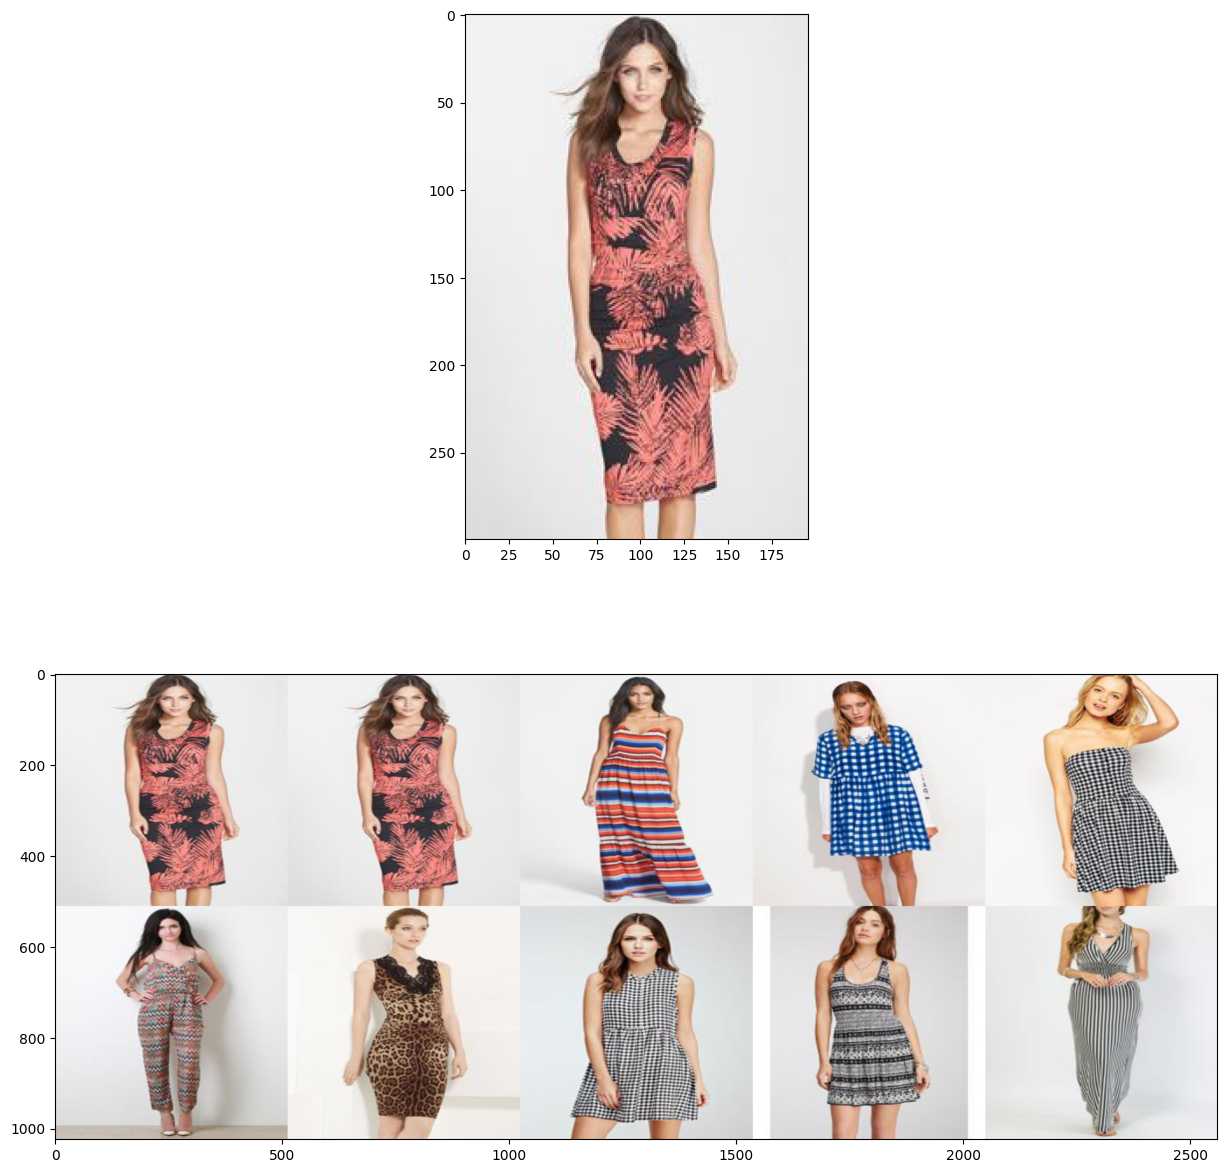

In [101]:
import cv2

# take the features for the current image, find all similar
# images in our dataset, and then initialize our list of result

# images
fig, ax = plt.subplots(nrows=2,figsize=(15,15))

# queryIdx 인덱스의 이미지를 검색합니다.
queryIdx = 724

# 검색 결과로 반환할 이미지의 개수를 설정합니다.
MAX_RESULTS = 10

# queryIdx 인덱스의 이미지를 검색합니다.
queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# 검색 결과 이미지들을 imgs 리스트에 추가합니다.
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j)
    imgs.append(img)

# query image를 시각화합니다.
ax[0].imshow(np.array(Image.open(images[queryIdx])))

# 검색 결과 이미지들을 모아 montage 이미지를 만들고 시각화합니다.
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)
